# Farm monitoring: multi-year crop extent, rotation and dynamics

## Background

crop rotation

              Dynamics of crop fields in Monmouthshire between Nov 2017 and Nov 2021 (Planet imagery)
              
              
<video controls autoplay width="960" height="540" src="https://storage.googleapis.com/planet-t2/monmouthshire_crops-IkhQm8S4g/movie.mp4" />


## Description

This notebook demonstrates .......


Topics include: 

1. Import an area of interest (e.g., a farm's field plots) from shapefile
2. Reporting on the annual  crop type area
3. Mapping crop rotation at farm scale
4. Mapping crop rotation at plot scale

### Jupyter Notebooks
#### Running (executing) a cell
Jupyter Notebooks allow code to be separated into sections that can be executed independent of one another.
These sections are called "cells".

Python code is written into individual cells that can be executed by placing the cursor in the cell and typing `Shift-Enter` on the keyboard or selecting the &#9658; "Run" button in the ribbon at the top of the notebook.
These options will run a single cell at a time.

When a cell is run, the cell's content is executed.
Any output produced from running the cell will appear directly below it.

Run the cell below as a test:

In [1]:
print("I ran a cell!")

I ran a cell!


#### Cell status
The `[ ]:` symbol to the left of each Code cell describes the state of the cell:

* `[ ]:` means that the cell has not been run yet.
* `[*]:` means that the cell is currently running.
* `[1]:` means that the cell has finished running and was the first cell run. The number indicates the order that the cells were run in.

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

In [2]:
# Import modules

import sys
sys.path.append("..")

import time
from time import time as now
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import geopandas as gpd
from ipyleaflet import GeoData

import warnings
warnings.filterwarnings("ignore")

import datacube
from datacube.utils.geometry import Geometry, CRS

import wales_utils.data_cube_utilities.display_tools as display_tools
from wales_utils.data_cube_utilities.wdc_datahandling import geom_fromdrawn, geopolygon_masking
from wales_utils.data_cube_utilities.crop import crop_type_widget, report_crop_type_area, play_crop_rotation

### Connect to the datacube
Connect to the datacube so we can access Living Wales Analysis Ready Data.

In [3]:
dc = datacube.Datacube()

### Import an area of interest (e.g., a farm's field plots) from shapefile

In [4]:
# Loading field plots from shapefile
field_plots = gpd.read_file('../Vectors/crops_study_area_27700.shp')

# Transform shapefile boundaries into geographic data (and affect a style) 
geo_data = GeoData(geo_dataframe = field_plots.to_crs(epsg=4326),
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 
                          'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Fields')

# map the geographic data
m =display_tools.map_geom(geo_data)
m

Map(center=[51.78935838407965, -2.9290692770219158], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Reporting on the annual  crop type area

For each plot of the hypothetical farm extent, the annual crop type was mapped (not shown here) and validated using Planet imagery, during the period 2018-2021.

In this section, we show how the data cube can help to report on the annual crop type area at farm scale.

#### Select a crop type of interest

Please select a crop type of interest. You can select one specific crop type or consider all of them

In [5]:
crop_type = crop_type_widget()
crop_type

RadioButtons(description='Crop type:', layout=Layout(width='max-content'), options=('All', 'Winter wheat', 'Ra…

#### Report

In [6]:
# Create report
report = report_crop_type_area(field_plots, crop_type.value)

# Print report
for year in report:
    print("\n  In "+year+":")
    for crop in list(report[year].keys()):
        print(str(round(report[year][crop],2))+" ha of "+ crop)


  In 2018:
20.13 ha of Rapeseed
56.06 ha of Winter wheat
15.69 ha of Other
8.56 ha of Maize
23.77 ha of Grass

  In 2019:
53.15 ha of Winter wheat
20.28 ha of Rapeseed
18.46 ha of Other
23.83 ha of Grass
8.5 ha of Maize

  In 2020:
12.6 ha of Other
48.76 ha of Winter wheat
17.78 ha of Rapeseed
12.74 ha of Spring wheat
21.67 ha of Grass
10.66 ha of Maize

  In 2021:
34.28 ha of Winter wheat
12.29 ha of Spring wheat
25.98 ha of Rapeseed
23.62 ha of Maize
12.8 ha of Grass
15.24 ha of Winter barley


## Mapping crop rotation at farm scale

Run the cell below to visualize crop rotation between 2018 and 2021 at farm scale.

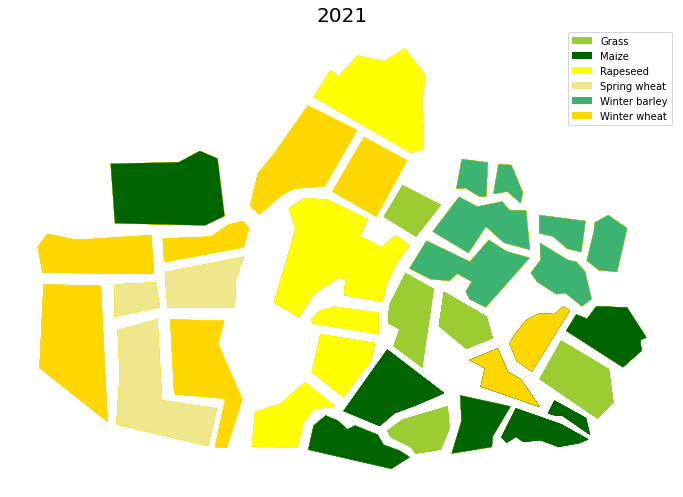

In [11]:
play_crop_rotation(field_plots)

## Mapping crop rotation at plot scale

### Select a field plot of interest

#### Map all the field plots

In [12]:
# Run display tool
m, option_widget=display_tools.draw_select(geo_data)
m.add_layer(geo_data)
m

Map(center=[51.78935838407965, -2.9290692770219158], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### Select a field plot of interest

In this section, we will interact with the above display tool to select a field plot from the shapefile. 

Unfortunately, currently, there is no ipython library available to click-select. As part of the Living Wales, we have developed an alternative to allow you to select a polygon feature.

- TO SELECT: use the &#9726; *'draw a rectangle'* symbol in the leftside bar, draw a small polygon **inside** the polygon you would like to select and click on the 'Select' button
- TO DELETE: at any time, you can click on the bin symbol and choose 'Clear All" to delete the polygon(s) you have drawn.


#### Use the selected field plot as the geopolygon of interest

The geopolygon of interest is the following one; 


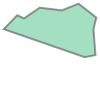

In [13]:
# Get the rectangle boundaries 
#geojson = display_tools.DRAW_GEOJSON_GEOM

# Select 
my_geopolygon, feature = geom_fromdrawn('Selection' , shapefile=field_plots)

print("The geopolygon of interest is the following one; ")
my_geopolygon

### Loading data from datacube 

#### Prepare query for datacube

In [14]:
# Use the whole study period as period of interest
start_date = '2017-10-01'
end_date = '2021-11-01'

# Prepare query
query = {'product': 'sen1_rtc_pyroSNAP',
             'geopolygon': my_geopolygon,
             'time': (start_date, end_date),
             'output_crs': 'epsg:27700',
             'measurements': ['VH','VV'],
             'resolution': (-10,10)}

#### Load data

In [15]:
# Preparing query for datacube
start_time = now()
# Let's load the dataset
dataset_in = dc.load(**query)

# define nodata
dataset_in = dataset_in.where(dataset_in != 0)

# clean data: drop dates with only nodata for the area of interest
dataset_in = dataset_in.dropna('time', how='all')

# When using epsg other than 4326 (here: 27700), latitude and longitude are renamed y and x.
# Let's correct that and rename x and y with explicit names
dataset_in = dataset_in.rename({'x': 'longitude', 'y': 'latitude'})

# group images by YYYY-MM-DD
S1_dataset = dataset_in.groupby(dataset_in.time.dt.strftime("%Y-%m-%d")).mean("time")
S1_dataset = S1_dataset.rename({'strftime': 'time'})

print("Datacube ready")
print("Took only " + str(round(now()-start_time,2)) + " seconds to load "+ str(len(S1_dataset.time
                                                                              )) +" images from datacube.")

Datacube ready
Took only 16.32 seconds to load 895 images from datacube.


Plotting ...
(Please wait until images appear. This may take a few seconds.)


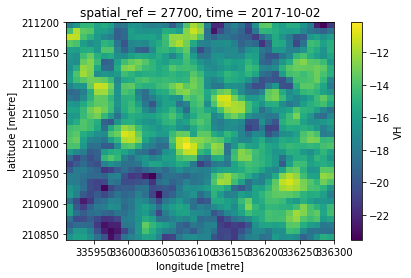

In [16]:
# Visualise VH backscatter for the first date in the dataset
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds.)")

S1_dataset.VH.isel(time=0).plot();

### Masking data out of the field plot

As you can see on the above figure, within the data cube, data are loaded as a geobox (i.e., a rectangle). 
In our case, in cell 9, we have queried a geopolygon. However, the data cube uses the maximum/minimum latitude/longitude of the polygon to load the data.

In this section, we will mask out the pixels which are not included within the draw/selected geopolygon using one of the tools developed by Living Wales.

Plotting ...
(Please wait until images appear. This may take a few seconds.)


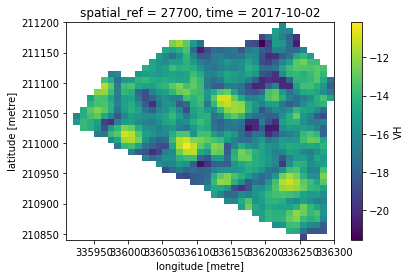

In [17]:
# Masking data out of the field plot
S1_dataset = geopolygon_masking(S1_dataset, my_geopolygon)

# Visualise VH backscatter for the first date in the dataset (after masking)
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds.)")

S1_dataset.VH.isel(time=0).plot();

### Mapping multi-year rotation

As with Sentinel-2, indices can be calculated using Sentinel-1. The polarization ratio is one of the most used index when analysing radar data.

In this section, for each available date, from the beginning of the period of interest (i.e., Oct 2017) to the end (i.e., Nov 2021), we calculate the parcel backscatter/index and plot its evolution.

In [18]:
# Calculate VH/VV ratio for each pixel
S1_dataset['Ratio'] = S1_dataset.VH - S1_dataset.VV

# Summarise the polarization ratio at parcel level
median_Ratio = S1_dataset.Ratio.median(['latitude','longitude'])

Plotting ...
(Please wait until images appear. This may take a few seconds.)


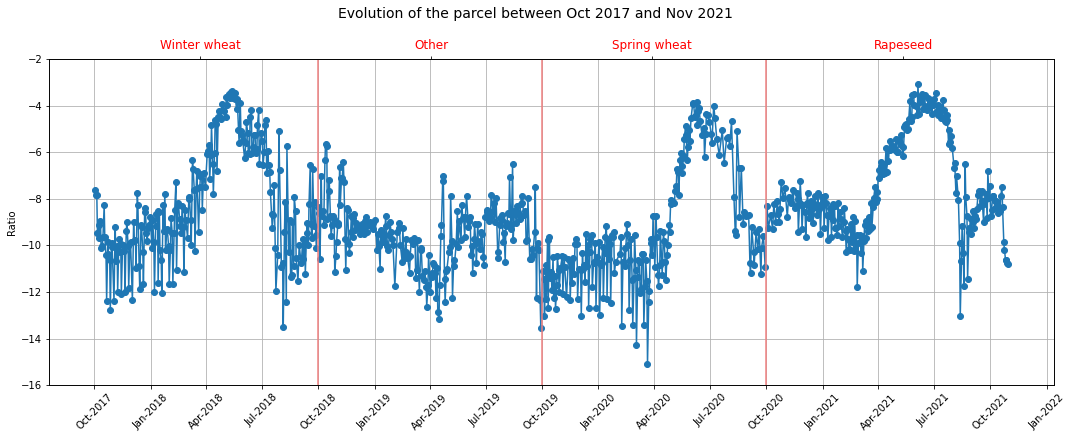

In [19]:
# Plotting the parcel backscatters/indices
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds.)")

# define figure size
fig, (ax1) = plt.subplots(1,figsize=(18,6));
# set title
fig.suptitle('Evolution of the parcel between Oct 2017 and Nov 2021', y=1, fontsize=14);
# set date format for the a axises
dates=[dt.datetime.strptime(d,'%Y-%m-%d').date() for d in median_Ratio.time.values]

# Plot the  ratio
ax1.plot(dates, median_Ratio.values, marker="o");
ax1.grid(visible=True, which='major', axis='both');
ax1.set_ylim([-16, -2]);
ax1.xaxis.set_major_locator(mdates.MonthLocator((1,4,7,10)));
ax1.xaxis.set_major_formatter(DateFormatter("%b-%Y"));
ax1.tick_params('x',labelrotation=45);
ax1.set_ylabel("Ratio");

ax1.axvline(x = dt.date(2018, 10, 1), color = 'lightcoral',linewidth=1.5);
ax1.axvline(x = dt.date(2019, 10, 1), color = 'lightcoral',linewidth=1.5);
ax1.axvline(x = dt.date(2020, 10, 1), color = 'lightcoral',linewidth=1.5);

crop = field_plots[field_plots.id==int(feature)]
ax2 = ax1.twiny();
ax2.set_xticks(ticks=[0.15, 0.38, 0.60, 0.85]);
ax2.tick_params(axis='x', which='major', labelsize=12);
ax2.set_xticklabels(labels= [crop['Year_2018'].values[0], crop['Year_2019'].values[0],
                            crop['Year_2020'].values[0], crop['Year_2021'].values[0]], color='red');